In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files

In [ ]:
# 1. Veri setini yükleme
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])

Saving Steel_industry_data.csv to Steel_industry_data.csv


In [ ]:
df.head(9)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load
5,01/01/2018 01:30,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday,Light_Load
6,01/01/2018 01:45,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday,Light_Load
7,01/01/2018 02:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday,Light_Load
8,01/01/2018 02:15,3.28,3.64,0.0,0.0,66.94,100.0,8100,Weekday,Monday,Light_Load


In [ ]:
# 2. Tarih sütununu datetime formatına çevirme ve sıralama
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df = df.sort_values('date')

In [ ]:

# 3. Özellikleri seçme ve ek sütunlar çıkarma
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.dayofweek
features = ['Usage_kWh', 'hour', 'day']
data = df[features]

In [ ]:
data.head(24)

,Usage_kWh,hour,day
95,3.42,0,0
0,3.17,0,0
1,4.00,0,0
2,3.24,0,0
3,3.31,1,0
4,3.82,1,0
5,3.28,1,0
6,3.60,1,0
7,3.60,2,0
8,3.28,2,0


In [ ]:
# 4. Veriyi normalize etme
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [ ]:
# 5. Zaman serisi pencereleme fonksiyonu
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Parametreler
sequence_length = 96  # 24 saatlik veri (15 dakikalık aralıklarla)
X, y = create_sequences(scaled_data, sequence_length)

In [ ]:
# 6. Eğitim ve test setlerine ayırma
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# 7. LSTM modelini oluşturma
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, len(features))),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 8. Modeli derleme
model.compile(optimizer='adam', loss='mse')

In [ ]:
# 9. Callbacks tanımlama
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

In [ ]:
# 10. Modeli eğitme
history = model.fit(X_train, y_train, epochs=24, batch_size=32, validation_split=0.1,
                    callbacks=[early_stopping, reduce_lr], verbose=1)


Epoch 1/24
787/787 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0202 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 2/24
787/787 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0082 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 3/24
787/787 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0073 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 4/24
787/787 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0064 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 5/24
787/787 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0060 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 6/24
787/787 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0057 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 7/24
787/787 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0060 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 8/24
787/787 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0055 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 9/24
787/787 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0055 - val_loss: 0.0042 - learning_rate:

In [ ]:
# 11. Tahmin yapma
y_pred = model.predict(X_test)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [ ]:
# 12. Normalizasyonu geri alma
y_test_reshaped = np.zeros((len(y_test), len(features)))
y_test_reshaped[:, 0] = y_test
y_pred_reshaped = np.zeros((len(y_pred), len(features)))
y_pred_reshaped[:, 0] = y_pred.flatten()

y_test_original = scaler.inverse_transform(y_test_reshaped)[:, 0]
y_pred_original = scaler.inverse_transform(y_pred_reshaped)[:, 0]


In [ ]:
# 13. Model değerlendirme
mse = mean_squared_error(y_test_original, y_pred_original)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 74.06965793087721


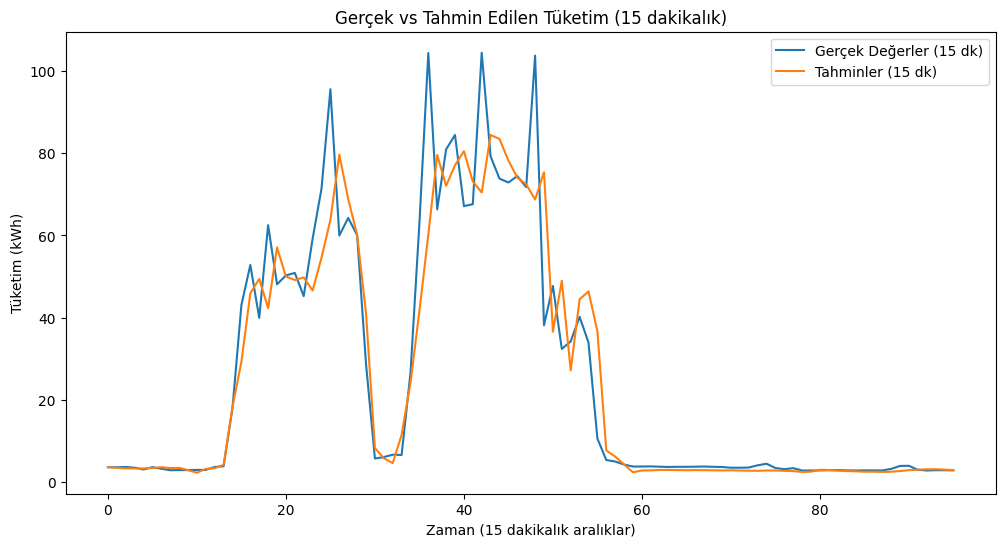

In [ ]:
# 14. Gerçek ve tahmin edilen verileri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:96], label='Gerçek Değerler (15 dk)')
plt.plot(y_pred_original[:96], label='Tahminler (15 dk)')
plt.xlabel('Zaman (15 dakikalık aralıklar)')
plt.ylabel('Tüketim (kWh)')
plt.title('Gerçek vs Tahmin Edilen Tüketim (15 dakikalık)')
plt.legend()
plt.show()

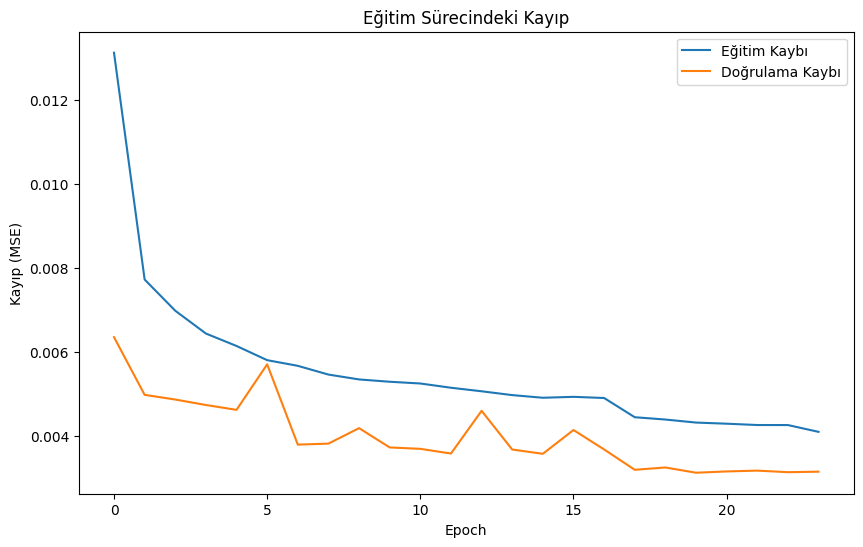

In [ ]:
# 15. Eğitim sürecini görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (MSE)')
plt.title('Eğitim Sürecindeki Kayıp')
plt.legend()
plt.show()
